In [1]:
import config
import sys
sys.path.append(config.root_path)
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import DataLoader

from util import show_dataset_prev
#jupyter nbconvert --to script membrane_dataset.ipynb

30 15 15 total: 60


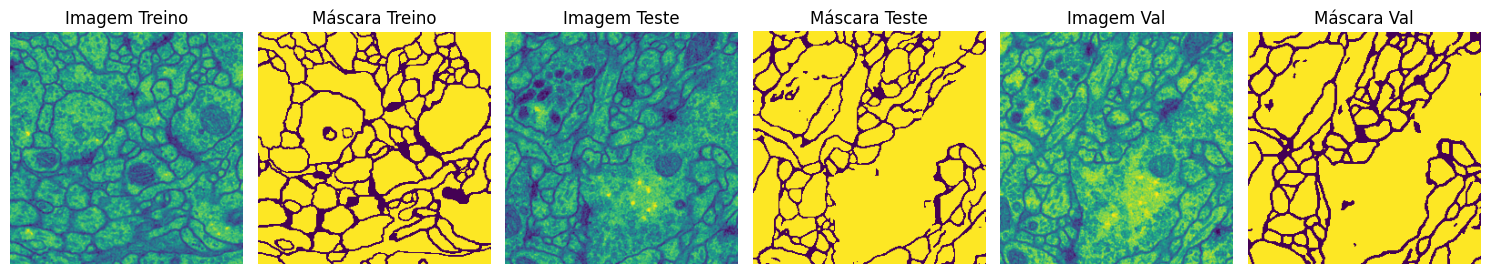

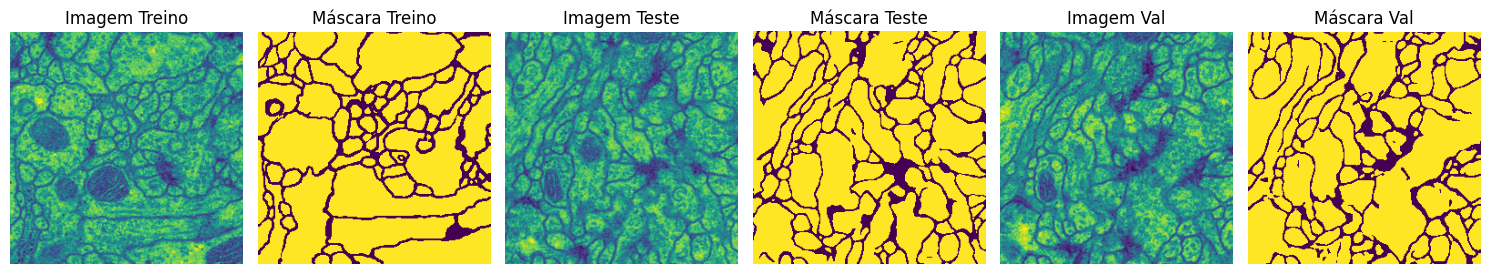

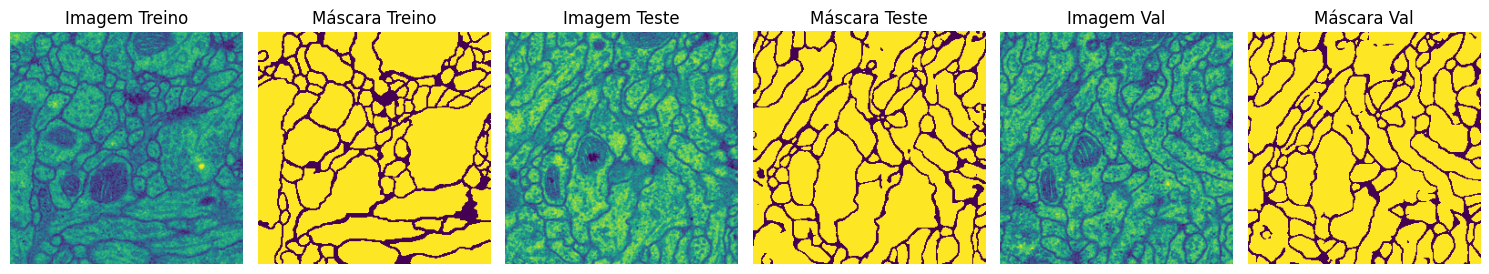

In [2]:

class MembraneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.mask_paths = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def get_membrane_datasets(dataset_dir, resolution=128, batch_size=16, augmented=False):

    # Definindo as transformações para normalizar e converter para tensor
    image_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),  # Converte para tensor de 1 canal
        transforms.Normalize([0.5], [0.5])  # se imagem for grayscale, ok
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),             # mantém valores 0 ou 1 se imagem for binária
        transforms.Lambda(lambda x: (x > 0.5).float())  # binariza se tiver 255
    ])

    if augmented:
        train_dataset = MembraneDataset(
            image_dir=f'{dataset_dir}train_aug/image',
            mask_dir=f'{dataset_dir}train_aug/label',
            image_transform=image_transform,
            mask_transform=mask_transform
        )
    else:
        train_dataset = MembraneDataset(
            image_dir=f'{dataset_dir}train/image',
            mask_dir=f'{dataset_dir}train/label',
            image_transform=image_transform,
            mask_transform=mask_transform
        )

    test_dataset = MembraneDataset(
        image_dir=f'{dataset_dir}test/image',
        mask_dir=f'{dataset_dir}test/label',
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    val_dataset = MembraneDataset(
        image_dir=f'{dataset_dir}validation/image',
        mask_dir=f'{dataset_dir}validation/label',
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)   
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)
    return train_loader, test_loader, val_loader


if __name__ == '__main__':
    dataset_path = config.dataset_path
    train_loader, test_loader, val_loader = get_membrane_datasets(dataset_path, resolution=256, batch_size=16)
    print(len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset), 'total:', len(train_loader.dataset)+ len(test_loader.dataset)+ len(val_loader.dataset))
    show_dataset_prev(train_loader, test_loader, val_loader, num_images=3)
